## In this tutorial, we aim to use Phoenix scenario from the DeepMIMO website

### In the design, the aim is to create dataset for the position based channel prediction task:
- **Task:** Given user position, predict channel between the user and basestation
    - **Input:** User Position
    - **Output:** User-BS Channel

### In the following:
- We adjust the parameters and generate a dataset
- Select a basestation
- Check the user channels' LOS status
- Select a subset of users with at least a single path
- Finally, collect the positions and channels of these users for the machine learning task

In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

# DeepMIMOv3 (and install through pip if not available)
import sys
sys.path.append('../src/')
import DeepMIMOv3
from DeepMIMOv3.visualization import plot_LoS_status

# Numpy and Matplotlib
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

In [2]:
# Load the default parameters
parameters = DeepMIMOv3.default_params()

# Print the default parameters
pprint(parameters)

{'OFDM': {'RX_filter': 0,
          'bandwidth': 0.05,
          'selected_subcarriers': array([0]),
          'subcarriers': 512},
 'OFDM_channels': 1,
 'active_BS': array([1]),
 'bs_antenna': {'FoV': array([360, 180]),
                'radiation_pattern': 'isotropic',
                'rotation': array([0, 0, 0]),
                'shape': array([8, 4]),
                'spacing': 0.5},
 'dataset_folder': './Raytracing_scenarios',
 'dynamic_scenario_scenes': array([1]),
 'enable_BS2BS': 1,
 'enable_doppler': 0,
 'enable_dual_polar': 0,
 'num_paths': 5,
 'scenario': 'O1_60',
 'ue_antenna': {'FoV': array([360, 180]),
                'radiation_pattern': 'isotropic',
                'rotation': array([0, 0, 0]),
                'shape': array([4, 2]),
                'spacing': 0.5},
 'user_rows': array([1]),
 'user_subsampling': 1}


A brief summary for the parameters ([For the detailed descriptions, please go to the version page]()):

| Parameter              | Default Value          | Description                                                                           |
|------------------------|------------------------|---------------------------------------------------------------------------------------|
| **dataset_folder**     | ./Raytracing_scenarios | Folder of the datasets                                                                |
| **scenario**           | O1_60                  | Scenario name - The .mat files of the scenario need to be in the path 'dataset_folder'/'scenario_name' |
|                        |                      |    |
| **active_BS**          | [1]                        | The ID of the basestations                                                        |
| **user_rows**          | [1]                        | User rows to be generated                                                          |
| **user_subsampling**   | 1                          | Random subsampling rate for users - 1 generates all the users                      |
| **dynamic_scenario_scenes** | [1]                   | Scenes to be generated in a dynamic scenario                                       |
|                        |                      |    |
| **enable_BS2BS**       | 1                          | Enable BS to BS channels                                                           |
| **enable_doppler**     | 0                          | Enable Doppler shift (if available in the scenario)                                |
| **enable_dual_polar**  | 0                          | Enable dual cross-polarized antennas (if available in the scenario)                |
|                        |                      |    |
| **num_paths**          | 5                          | Number of maximum paths                                                            |
| **OFDM_channels**      | 1                          | Generate OFDM (True) or time domain channels (False)                               |
| **OFDM**               |                            | OFDM parameters (only applies if OFDM_channels is True)                            |
|   - **subcarriers**    | 512                        | Total number of subcarriers                                                        |
|   - **selected_subcarriers** | [0]                  | Subcarriers to be generated                                                        |
|   - **bandwidth**      | 0.05                       | Bandwidth                                                                          |
|   - **RX_filter**      | 0                          | Receive filter                                                                     |
|                        |                      |    |
| **bs_antenna**/**ue_antenna**         |                            | BS/UE antenna properties                                            |
|   - **FoV**            | [360, 180]                 | Antenna FoV Horizontal in [0,360] and vertical in [0, 180]                         |
|   - **radiation_pattern** | isotropic              | Radiation pattern applied to the antenna, in ['isotropic', 'halfwave-dipole']       |
|   - **rotation**       | [0, 0, 0]                  | Rotation of the antenna - in compliance with 38.901                                |
|   - **shape**          | [8, 4]                     | UPA panel shape in the shape of (horizontal elements, vertical elements)           |
|   - **spacing**        | 0.5                        | Antenna spacing                                                                    |

Scenario folders are extracted into "./Raytracing_scenarios"

Specifically, the phoenix scenario zip file is extracted into this folder. The scenario *.mat* files are inside "./Raytracing_scenarios/city_4_phoenix".

We set these parameters accordingly:

In [3]:
parameters['dataset_folder'] = r'../raytracing_scenarios'
parameters['scenario'] = 'city_4_phoenix'

There are 3 basestation in the scenario. Let us generate the data for all 3 of them.

In [4]:
parameters['active_BS'] = np.array([1, 2, 3])

We want to generate all the users to visualize and subselect. There are 79 rows of users with 86 users in each row, as described in [the scenario page](https://www.deepmimo.net/scenarios/deepmimo-city-scenario4/)

In [5]:
parameters['user_rows'] = np.arange(79)

In this scenario, we consider a MISO case, i.e., single UE antenna with a 8-element ULA at the basestation

In [6]:
parameters['ue_antenna']['shape'] = np.array([1, 1])
parameters['bs_antenna']['shape'] = np.array([8, 1])

We now can generate the dataset with the adjusted parameters:

In [7]:
dataset = DeepMIMOv3.generate_data(parameters)


Basestation 1

UE-BS Channels


Generating channels: 100%|██████████| 6794/6794 [00:00<00:00, 7077.11it/s]



BS-BS Channels


Generating channels: 100%|██████████| 3/3 [00:00<00:00, 1501.18it/s]



Basestation 2

UE-BS Channels


Generating channels: 100%|██████████| 6794/6794 [00:00<00:00, 10682.50it/s]



BS-BS Channels


Generating channels: 100%|██████████| 3/3 [00:00<00:00, 1503.16it/s]



Basestation 3

UE-BS Channels


Generating channels: 100%|██████████| 6794/6794 [00:00<00:00, 39272.41it/s]



BS-BS Channels


Generating channels: 100%|██████████| 3/3 [00:00<00:00, 2990.24it/s]


Next, we visualize the LoS status (if the channel has -1: no path, 0: pnly NLoS paths, 1: LoS path) of the user channels. For this purpose, we need the LoS status of the user channels and position. From the output section of [the DeepMIMOv3-python page](https://www.deepmimo.net/versions/deepmimo-v3-python/), we check the commands needed to access these parameters, and collect them in new variables for plotting.

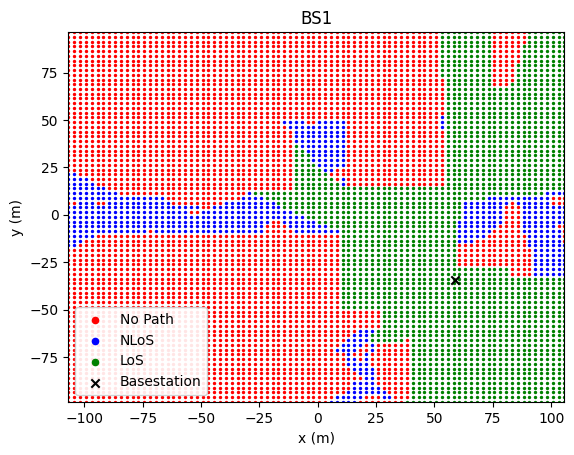

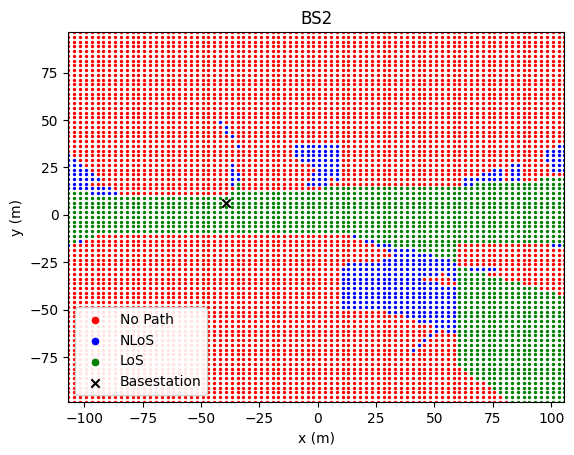

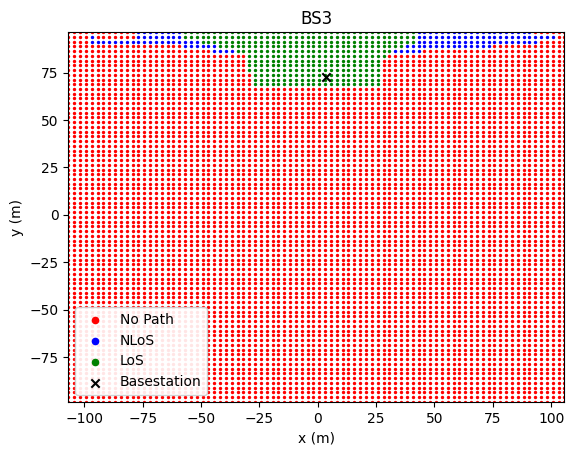

In [8]:
for bs_idx in [0, 1, 2]:
    bs_location = dataset[bs_idx]['location']
    LoS_status = dataset[bs_idx]['user']['LoS']
    user_location = dataset[bs_idx]['user']['location']
    plt.figure()
    plot_LoS_status(bs_location, user_location, LoS_status)
    plt.title(f'BS{bs_idx+1}')

If we want to select only the users with LoS paths to BS2 to be used in ML model, we can apply the following:

Text(0.5, 1.0, 'BS2')

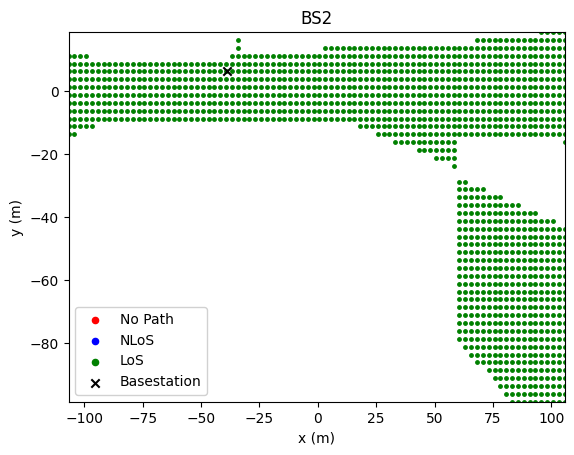

In [9]:
bs_idx = 1
LoS_status = dataset[bs_idx]['user']['LoS']
selected_users = LoS_status == 1

bs_location = dataset[bs_idx]['location']
LoS_status = dataset[bs_idx]['user']['LoS'][selected_users]
user_locations = dataset[bs_idx]['user']['location'][selected_users]
plt.figure()
plot_LoS_status(bs_location, user_locations, LoS_status)
plt.title(f'BS{bs_idx+1}')

### Data for ML

The data to be used in the model then can be expressed as

In [10]:
location = dataset[bs_idx]['user']['location'][selected_users] # ML model input
channels = dataset[bs_idx]['user']['channel'][selected_users] # ML model output
print('Channel data shape:', channels.shape) # num_UEs x num_RX_ant x num_TX_ant x num_OFDM_subcarriers
print('Location data shape:', location.shape) # num_UEs x 3 (x, y, z)

Channel data shape: (1368, 1, 8, 1)
Location data shape: (1368, 3)


# Applying FoV
The newly introduced field of view property for the antennas allow basestation to limit the transmit/receive angle of the paths. For example, for a ULA, it is more reasonable to only use the channels through the halfspace the antenna is directed at. For this, we change the TX antenna FoV parameter to (180, 180), which takes 180 degrees horizontal FOV with 180 degrees vertical FOV.

**Note:** *The parameters need to be re-initiated for a generation. The parameters after generation of a dataset is changed based on the generation of the dataset, showing additional information based on the scenario.*


Basestation 2

UE-BS Channels


Generating channels: 100%|██████████| 6794/6794 [00:00<00:00, 10155.48it/s]



BS-BS Channels


Generating channels: 100%|██████████| 1/1 [00:00<00:00, 1003.18it/s]


Text(0.5, 1.0, 'BS 2')

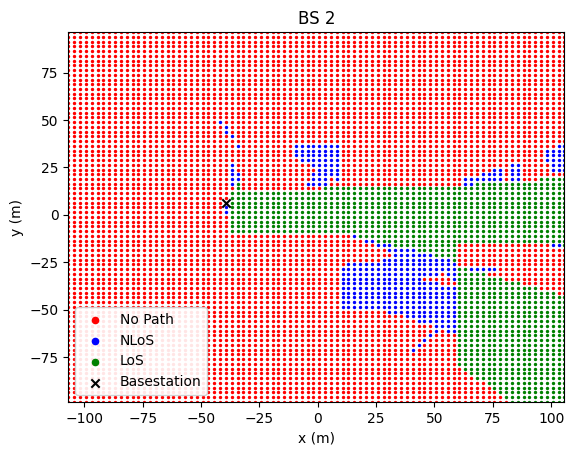

In [11]:
parameters = DeepMIMOv3.default_params()
parameters['dataset_folder'] = r'C:\Users\Umt\Desktop\deepverse_scenarios'
parameters['scenario'] = 'city_4_phoenix'
parameters['active_BS'] = np.array([2]) # Only generate the data for the second basestation
parameters['user_rows'] = np.arange(79)
parameters['ue_antenna']['shape'] = np.array([1, 1])
parameters['bs_antenna']['shape'] = np.array([8, 1])
parameters['bs_antenna']['FoV'] = np.array([180, 180])
parameters['bs_antenna']['rotation'] = np.array([0, 0, 0]) # +x rotation
dataset = DeepMIMOv3.generate_data(parameters.copy())

bs_location = dataset[0]['location']
LoS_status = dataset[0]['user']['LoS']
user_locations = dataset[0]['user']['location']
plt.figure()
plot_LoS_status(bs_location, user_locations, LoS_status)
plt.title(f"BS {parameters['active_BS'][0] }")

Now, we rotate the basestation 90 degrees towards +y


Basestation 2

UE-BS Channels


Generating channels: 100%|██████████| 6794/6794 [00:00<00:00, 10598.97it/s]



BS-BS Channels


Generating channels: 100%|██████████| 1/1 [00:00<00:00, 998.88it/s]


Text(0.5, 1.0, 'BS 2')

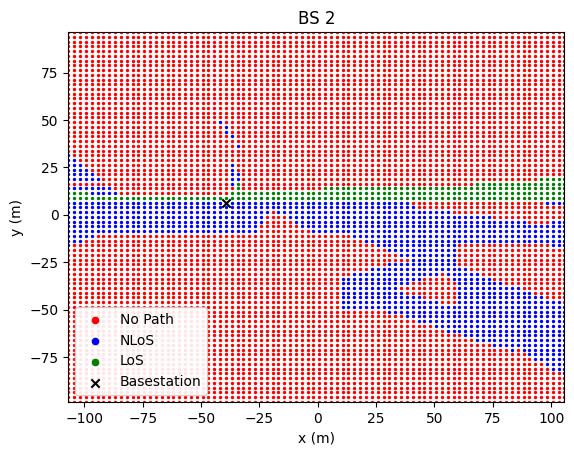

In [12]:
parameters['bs_antenna']['rotation'] = np.array([0, 0, 90]) # let's rotate it to +y
dataset = DeepMIMOv3.generate_data(parameters.copy())

bs_location = dataset[0]['location']
LoS_status = dataset[0]['user']['LoS']
user_locations = dataset[0]['user']['location']
plt.figure()
plot_LoS_status(bs_location, user_locations, LoS_status)
plt.title(f"BS {parameters['active_BS'][0] }")


Basestation 2

UE-BS Channels


Generating channels: 100%|██████████| 6794/6794 [00:00<00:00, 11550.29it/s]



BS-BS Channels


Generating channels: 100%|██████████| 1/1 [00:00<00:00, 992.50it/s]


Text(0.5, 1.0, 'BS 2')

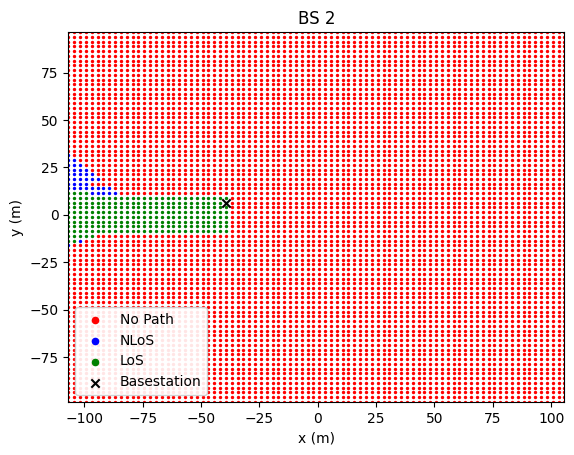

In [13]:
parameters['bs_antenna']['rotation'] = np.array([0, 0, 180]) # let's rotate it to +y
dataset = DeepMIMOv3.generate_data(parameters.copy())

bs_location = dataset[0]['location']
LoS_status = dataset[0]['user']['LoS']
user_locations = dataset[0]['user']['location']
plt.figure()
plot_LoS_status(bs_location, user_locations, LoS_status)
plt.title(f"BS {parameters['active_BS'][0] }")